## Bootstrap estimation of the error size for Sigma/Delta Sigma profiles

In [3]:
## testing multidark
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pickle
import pandas as pd
import h5py
import tables
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os

In [6]:
import sys
sys.path.append('/global/u1/z/zzhang13')
from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Import the files

In [8]:
datadir = './'

In [9]:
## Read the Files. 
files = ['sigma_mvir_5e13_1e14_z0p00.pkl', 'sigma_mvir_1e14_2e14_z0p00.pkl', 'sigma_mvir_2e14_5e14_z0p00.pkl', 'sigma_mvir_5e14_1e15_z0p00.pkl']
mvir_bins = ['5e13-1e14', '1e14-2e14', '2e14-5e14', '5e14-1e15']
r_range_norm = np.logspace(-0.15,1,10) #Used for computing the files. 

## Custom functions

In [7]:
def calc_bootstrap_cov_DS_radii(y, nBootstrap=50):     
    output_Data = {}
    
    cov_bins = len(y[0,:])
    covariance = np.zeros((cov_bins, cov_bins, nBootstrap))
    correlation = np.zeros((cov_bins, cov_bins, nBootstrap))
    
    for i in range(cov_bins):
        y_i = y[:,i]
        for j in range(cov_bins):
            y_j = y[:,j]
    
            for k in range(nBootstrap):
                #First "bootstrap" is always using unsampled data
                if k == 0:
                    rand_ind = np.ones(y_i.size).astype(bool)
                else:
                    rand_ind = np.random.randint(0, y_i.size, y_i.size)

                # Store the shuffled variables so you don't have to
                # compute the shuffle multiple times
                y_i_rand = y_i[rand_ind]
                y_j_rand = y_j[rand_ind]

                #Compute the covariance
                cov = np.cov(y_i_rand, y_j_rand)
                covariance[i,j,k] = cov[1, 0]     
                correlation[i,j,k] = cov[1, 0]/np.sqrt(cov[0,0] * cov[1,1])    
    
    output_Data['covariance'] = covariance
    output_Data['correlation'] = correlation
    return output_Data

## Computing the bootstrap error

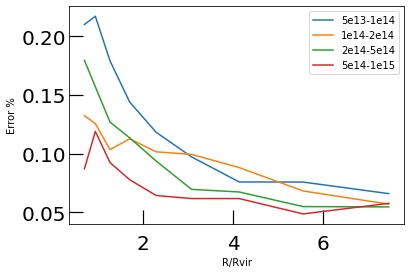

In [14]:
#sigma_mvir_binned = {}
for i, file in enumerate(files):
    with open(datadir+file, 'rb') as handle: 
        sigma_output = pickle.load(handle)
        output = calc_bootstrap_cov_DS_radii(sigma_output['sigma'], nBootstrap=100)
        
        
        covariance = output['covariance']
        correlation = output['correlation']
        
        err = np.std(covariance,axis=2)
        mean = np.mean(covariance,axis=2)
        rel_err = err/mean
        
        rel_err_diag = [rel_err[i,i] for i in range(len(rel_err))]
        plt.plot(r_range_norm[:-1], rel_err_diag, label=mvir_bins[i])
plt.xlabel('R/Rvir')
plt.ylabel('Error %')
plt.legend()
plt.show()